In [ ]:
# Import libraries
import pandas as pd
import networkx as nx
import numpy as np
import itertools
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt

# Load the preprocessed dataset
file_path = "data/processedDataset/Preprocessed_Comorbidity_Data_PS2.csv"
df = pd.read_csv(file_path)

# Display dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135708 entries, 0 to 135707
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   year             135708 non-null  int64  
 1   icd_code         135708 non-null  object 
 2   p                135708 non-null  float64
 3   sex_Male         135708 non-null  int64  
 4   Age_Group_10-19  135708 non-null  int64  
 5   Age_Group_20-29  135708 non-null  int64  
 6   Age_Group_30-39  135708 non-null  int64  
 7   Age_Group_40-49  135708 non-null  int64  
 8   Age_Group_50-59  135708 non-null  int64  
 9   Age_Group_60-69  135708 non-null  int64  
 10  Age_Group_70-79  135708 non-null  int64  
 11  time_period      135708 non-null  object 
dtypes: float64(1), int64(9), object(2)
memory usage: 12.4+ MB


In [ ]:
# Display first few rows
df.head()

year icd_code         p  sex_Male  Age_Group_10-19  Age_Group_20-29  \
0  2003      A01  0.000154         0                0                0   
1  2003      A02  0.048248         0                0                0   
2  2003      A04  0.017005         0                0                0   
3  2003      A05  0.000615         0                0                0   
4  2003      A07  0.000410         0                0                0   

   Age_Group_30-39  Age_Group_40-49  Age_Group_50-59  Age_Group_60-69  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Age_Group_70-79 time_period  
0                0   2003-2008  
1                0   2003-2008  
2                0   2003-2008  
3                0   2003-2008  
4                0   2003-2008

In [ ]:
# Step 1: Filter for High-Prevalence Diseases
prevalence_threshold = 0.05  # Minimum prevalence to consider a disease

# Dictionary to store networks
networks_optimized = {}

# Function to calculate OR and p-value
def calculate_odds_ratio(a, b, c, d):
    """Calculates the Odds Ratio (OR) and p-value for disease co-occurrence."""
    try:
        odds_ratio, p_value = fisher_exact([[a, b], [c, d]])
        return odds_ratio, p_value
    except:
        return None, None

# Batch processing for network construction
for period in df['time_period'].unique():
    # Filter and get frequent diseases only
    df_period = df[(df['time_period'] == period) & (df['p'] > prevalence_threshold)]
    diseases = df_period['icd_code'].unique()

    # Dictionary for prevalence lookup
    prevalence_dict = df_period.set_index('icd_code')['p'].to_dict()

    # Create network
    G = nx.Graph()
    G.add_nodes_from(diseases)

    # Compute disease co-occurrences in batches
    disease_pairs = list(itertools.combinations(diseases, 2))
    batch_size = 5000  # Process pairs in smaller batches
    for i in range(0, len(disease_pairs), batch_size):
        batch = disease_pairs[i:i+batch_size]
        results = []

        for disease_A, disease_B in batch:
            p_A = prevalence_dict[disease_A]
            p_B = prevalence_dict[disease_B]

            # Approximate contingency table values
            a = int(p_A * len(df_period))
            b = int((1 - p_A) * len(df_period))
            c = int(p_B * len(df_period))
            d = int((1 - p_B) * len(df_period))

            # Calculate OR and p-value
            OR, p_val = calculate_odds_ratio(a, b, c, d)
            if OR and OR > 1.5 and p_val < 0.05:
                results.append((disease_A, disease_B, OR))

        # Add edges to the graph
        for res in results:
            G.add_edge(res[0], res[1], weight=res[2])

    # Store the optimized graph
    networks_optimized[period] = G

# Summary of optimized networks
network_sizes_optimized = {period: (len(G.nodes), len(G.edges)) for period, G in networks_optimized.items()}
network_sizes_optimized

{'2003-2008': (122, 1606), '2009-2014': (124, 1518)}

In [ ]:
# Step 2: Compute Centrality Measures

# Dictionary to store centrality measures for each period
centrality_measures = {}

for period, G in networks_optimized.items():
    print(f"Processing centrality measures for {period}...")

    # Compute centrality metrics
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

    # Store results in a DataFrame
    df_centrality = pd.DataFrame({
        'ICD-10': list(G.nodes),
        'Degree Centrality': [degree_centrality[node] for node in G.nodes],
        'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes],
        'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes]
    })

    # Sort by Degree Centrality
    df_centrality = df_centrality.sort_values(by='Degree Centrality', ascending=False)

    # Save results as CSV
    file_path = f"centrality_analysis_{period}.csv"
    df_centrality.to_csv(file_path, index=False)

    # Print top 10 central diseases
    print(f"\nTop 10 Diseases by Degree Centrality for {period}:")
    print(df_centrality[['ICD-10', 'Degree Centrality']].head(10))

    # Store in dictionary
    centrality_measures[period] = df_centrality

print("\nCentrality analysis complete. CSV files are saved for each time period.")

Processing centrality measures for 2003-2008...

Top 10 Diseases by Degree Centrality for 2003-2008:
   ICD-10  Degree Centrality
12    J20           0.884298
17    K40           0.842975
5     H65           0.776860
10    J06           0.727273
11    J18           0.603306
14    K02           0.578512
24    J44           0.528926
30    F10           0.520661
29    A63           0.495868
54    N97           0.462810
Processing centrality measures for 2009-2014...

Top 10 Diseases by Degree Centrality for 2009-2014:
   ICD-10  Degree Centrality
13    J20           0.878049
5     H65           0.804878
20    K40           0.756098
12    J18           0.699187
16    J44           0.650407
9     J04           0.560976
55    N97           0.439024
53    N80           0.414634
73    H25           0.406504
74    I25           0.406504

Centrality analysis complete. CSV files are saved for each time period.


In [ ]:
!pip install python-louvain

In [ ]:
# Step 3: Community Detection using Louvain Method
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt

# Dictionary to store detected communities
community_results = {}

for period, G in networks_optimized.items():
    print(f"Processing community detection for {period}...")

    # Apply Louvain method for community detection
    partition = community_louvain.best_partition(G, weight='weight')

    # Convert to DataFrame
    df_community = pd.DataFrame(list(partition.items()), columns=['ICD-10', 'Community'])

    # Save results as CSV
    file_path = f"community_detection_{period}.csv"
    df_community.to_csv(file_path, index=False)

    # Print summary
    print(f"\nTop 5 Disease Communities for {period}:")
    print(df_community['Community'].value_counts().head(5))

    # Store results
    community_results[period] = df_community

print("\nCommunity detection complete. CSV files are saved for each time period.")

Processing community detection for 2003-2008...

Top 5 Disease Communities for 2003-2008:
Community
5    63
4    55
0     1
1     1
2     1
Name: count, dtype: int64
Processing community detection for 2009-2014...

Top 5 Disease Communities for 2009-2014:
Community
1    67
0    56
2     1
Name: count, dtype: int64

Community detection complete. CSV files are saved for each time period.


Displaying structured network for 2003-2008...


<ipython-input-24-10474400a802>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("rainbow", num_communities)


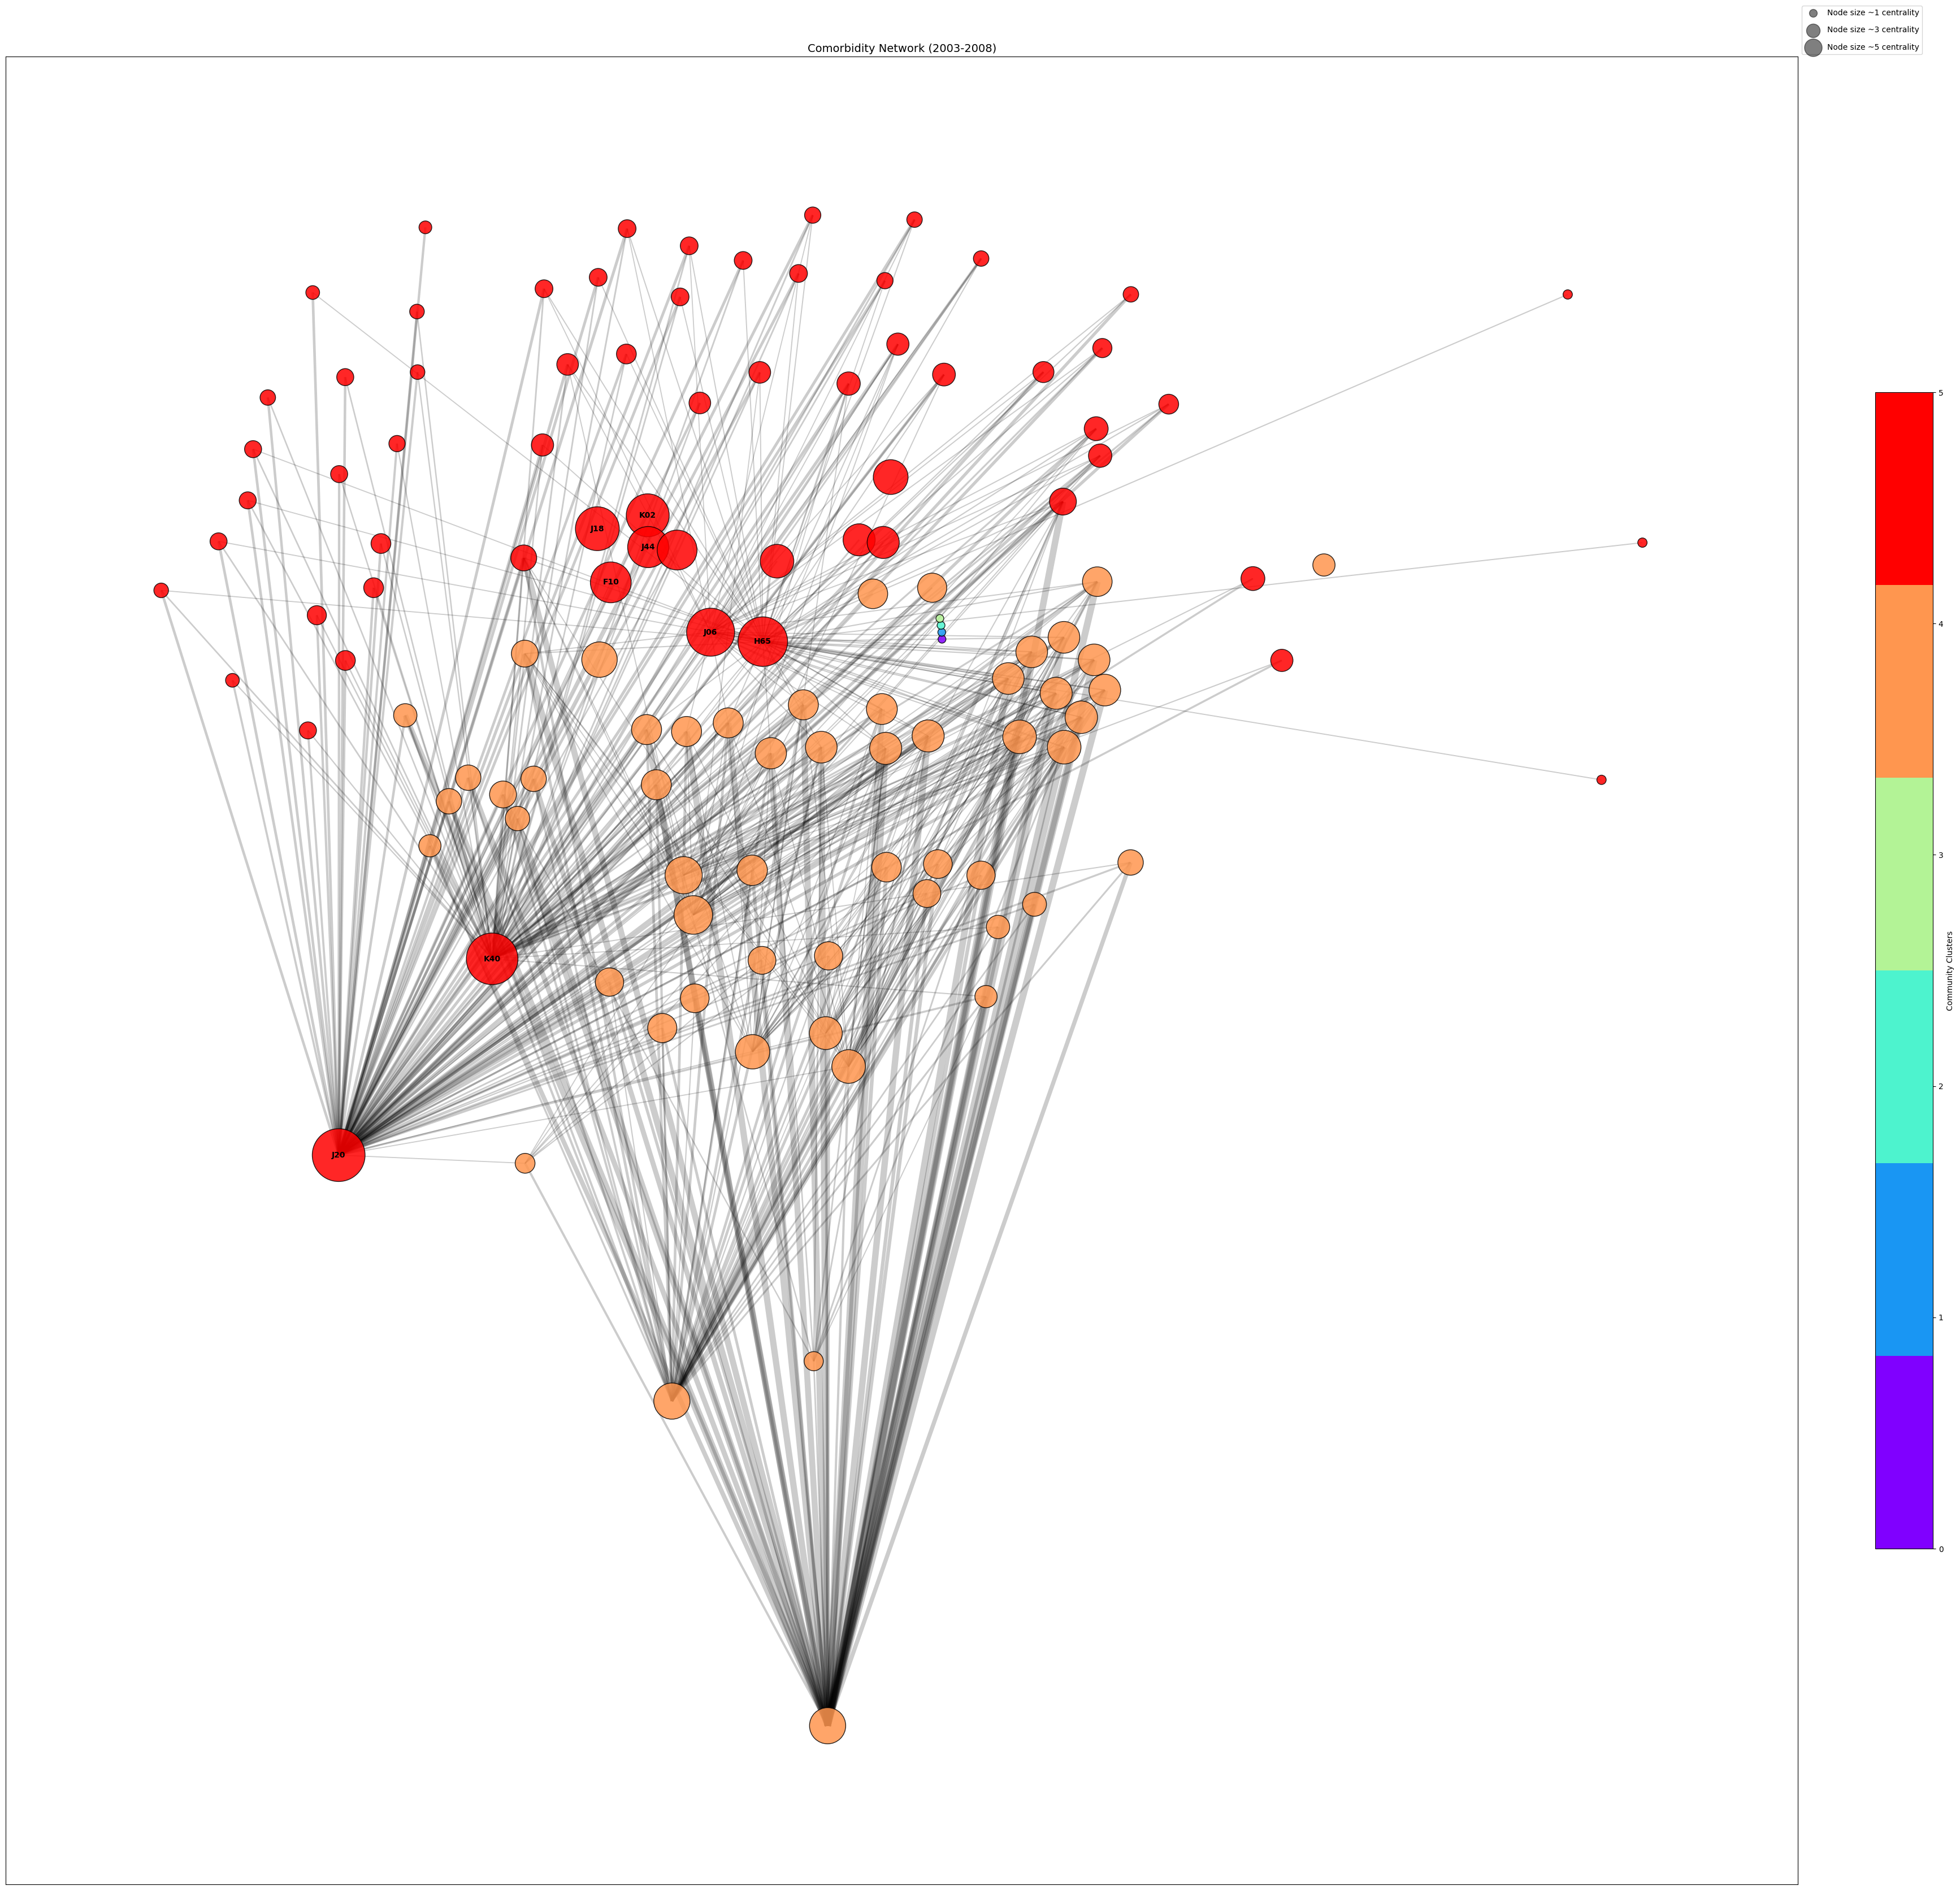

Displaying structured network for 2009-2014...


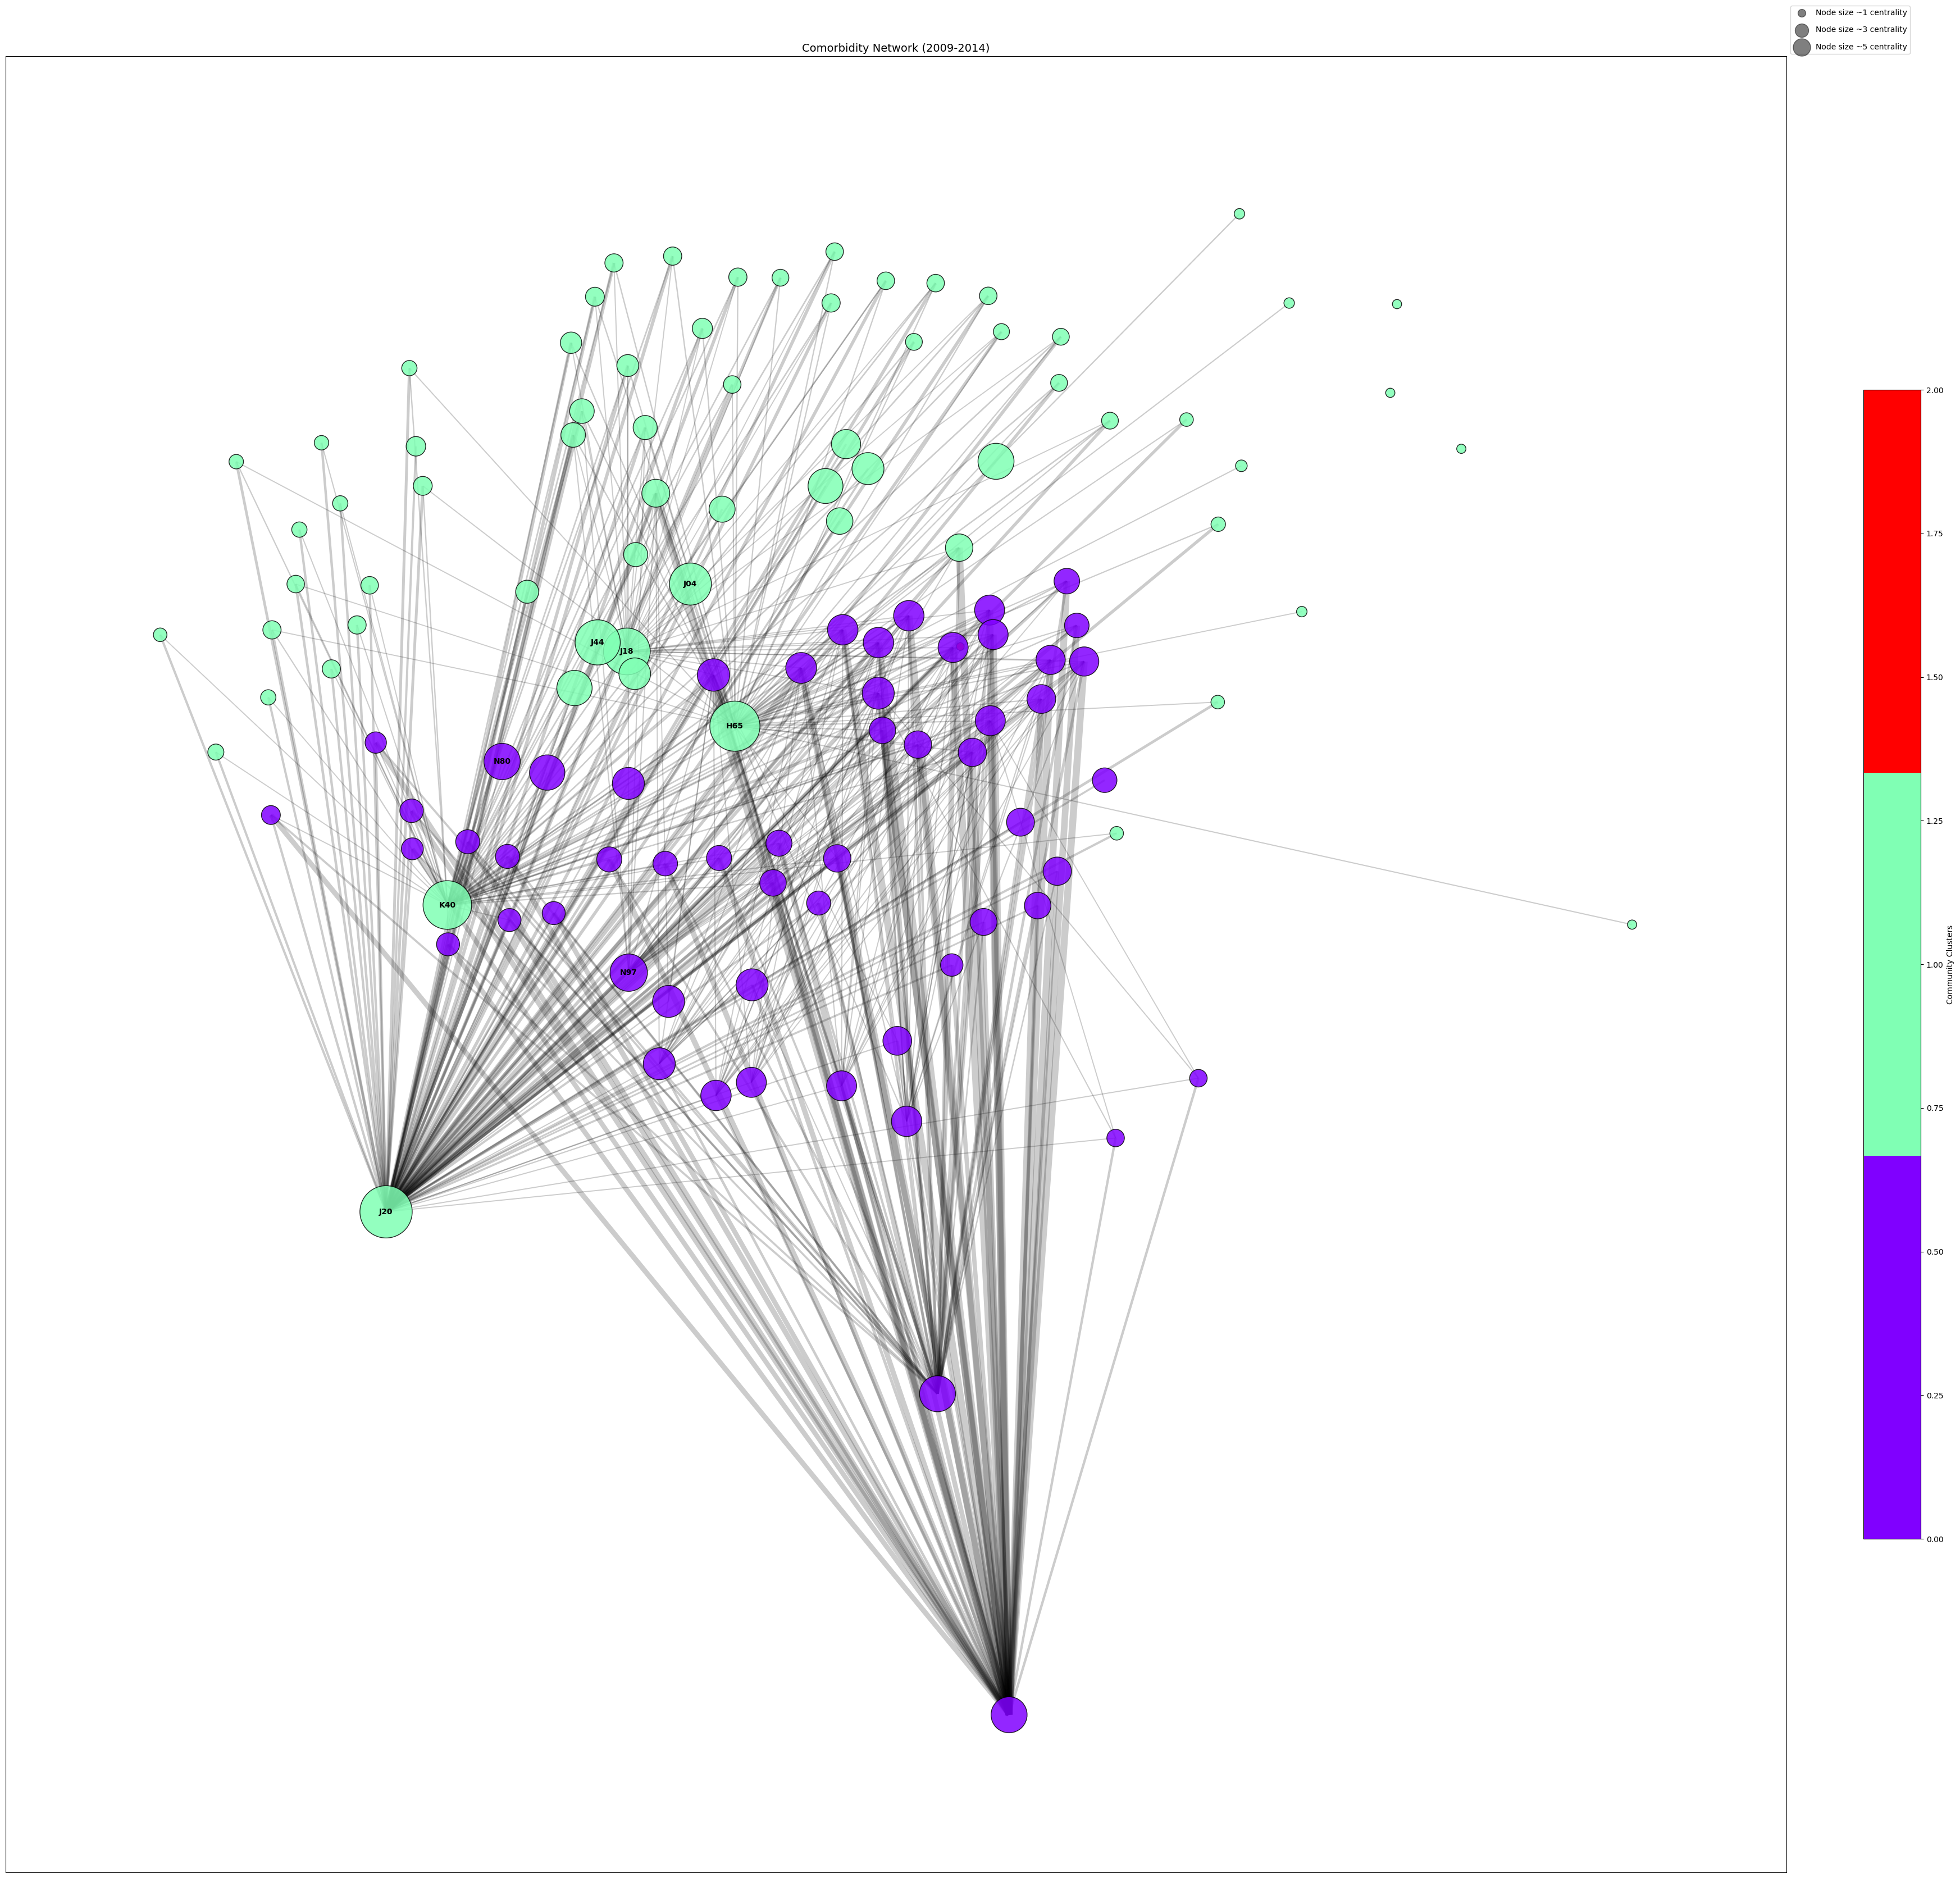

In [ ]:
# Step 4: Network Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

def plot_network(G, partition, title):
    """Visualize the comorbidity network with a more spread-out layout and reduced clutter."""
    fig, ax = plt.subplots(figsize=(44, 42))

    # Use Kamada-Kawai layout with increased scale for spacing
    pos = nx.kamada_kawai_layout(G, scale=15.0)

    # Get unique community values and normalize them for colormap
    communities = np.array(list(set(partition.values())))
    communities.sort()
    num_communities = len(communities)

    # Use a discrete colormap based on actual community values
    cmap = cm.get_cmap("rainbow", num_communities)
    color_mapping = {comm: i for i, comm in enumerate(communities)}
    node_colors = [color_mapping[partition[node]] for node in G.nodes()]

    # Normalize color mapping for the colorbar
    norm = mcolors.Normalize(vmin=communities.min(), vmax=communities.max())

    # Node sizes based on degree centrality
    degree_centrality = nx.degree_centrality(G)
    node_sizes = [5000 * degree_centrality[node] + 100 for node in G.nodes()]  # Scale up sizes

    # Filter edges: Keep only the strongest 30% of connections
    edge_weights = np.array([d['weight'] for u, v, d in G.edges(data=True)])
    weight_threshold = np.percentile(edge_weights, 70)  # Keep top 30% of edges
    filtered_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= weight_threshold]

    # Draw edges with reduced thickness to reduce clutter
    edge_widths = [d['weight'] * 0.5 for u, v, d in G.edges(data=True) if d['weight'] >= weight_threshold]
    nx.draw_networkx_edges(G, pos, edgelist=filtered_edges, alpha=0.2, width=edge_widths)

    # Draw nodes with assigned community colors
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=cmap,
                                   node_color=node_colors, alpha=0.85, edgecolors="black")

    # Add labels only for the most central nodes
    central_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:8]
    labels = {node: node for node, _ in central_nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight="bold")

    # Fix colorbar with correct alignment
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label("Community Clusters")

    # Fix node size legend placement and avoid overlapping
    legend_sizes = [100, 300, 500]  # Example sizes
    legend_labels = [f"Node size ~{size//100} centrality" for size in legend_sizes]
    handles = [plt.scatter([], [], c="black", alpha=0.5, s=size) for size in legend_sizes]
    legend = ax.legend(handles, legend_labels, scatterpoints=1, frameon=True,
                       labelspacing=1.2, loc="upper left", bbox_to_anchor=(1, 1.03))

    plt.title(title, fontsize=14)
    plt.show()

# Plot the networks for each time period
for period, G in networks_optimized.items():
    partition = community_results[period].set_index('ICD-10')['Community'].to_dict()
    print(f"Displaying structured network for {period}...")
    plot_network(G, partition, f"Comorbidity Network ({period})")



Comparing 2003-2008 → 2009-2014:
- Nodes: 122 → 124
- Edges: 1606 → 1518

Saved degree centrality changes to temporal_analysis_degree_changes_2003-2008_to_2009-2014.csv


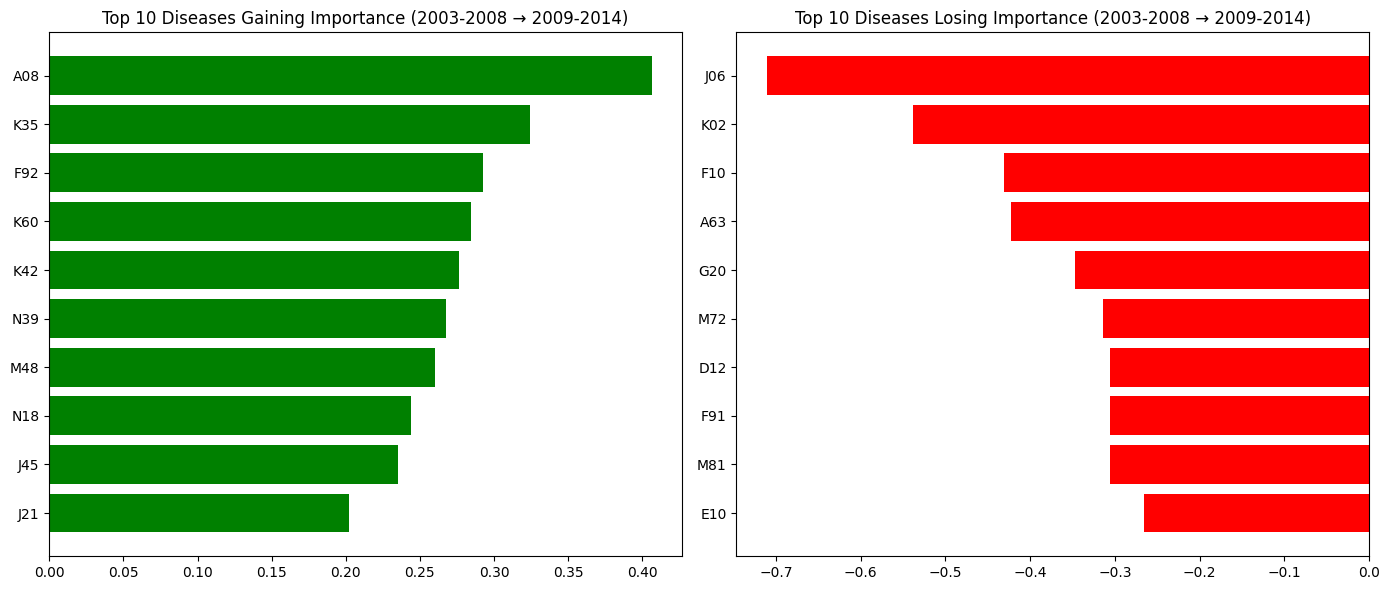


Temporal analysis complete with visualizations.


In [ ]:
# Step 5: Temporal Analysis - Network Evolution Over Time
import pandas as pd
import matplotlib.pyplot as plt

# Function to compare network structures
def compare_networks(G1, G2, period1, period2):
    """Compare network structure between two time periods and visualize changes."""
    print(f"\nComparing {period1} → {period2}:")

    # Basic network stats
    print(f"- Nodes: {len(G1.nodes)} → {len(G2.nodes)}")
    print(f"- Edges: {len(G1.edges)} → {len(G2.edges)}")

    # Find diseases that gained or lost connections
    degree_G1 = nx.degree_centrality(G1)
    degree_G2 = nx.degree_centrality(G2)

    df_degree = pd.DataFrame({'ICD-10': list(set(degree_G1.keys()).union(degree_G2.keys()))})
    df_degree[f'Degree_{period1}'] = df_degree['ICD-10'].map(degree_G1).fillna(0)
    df_degree[f'Degree_{period2}'] = df_degree['ICD-10'].map(degree_G2).fillna(0)
    df_degree['Change'] = df_degree[f'Degree_{period2}'] - df_degree[f'Degree_{period1}']

    # Save changes as CSV
    file_path = f"temporal_analysis_degree_changes_{period1}_to_{period2}.csv"
    df_degree.to_csv(file_path, index=False)
    print(f"\nSaved degree centrality changes to {file_path}")

    # Plot top 10 increasing and decreasing diseases
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Top 10 Increasing
    top_increasing = df_degree.nlargest(10, 'Change')
    ax[0].barh(top_increasing['ICD-10'], top_increasing['Change'], color="green")
    ax[0].set_title(f"Top 10 Diseases Gaining Importance ({period1} → {period2})")
    ax[0].invert_yaxis()  # Highest at the top

    # Top 10 Decreasing
    top_decreasing = df_degree.nsmallest(10, 'Change')
    ax[1].barh(top_decreasing['ICD-10'], top_decreasing['Change'], color="red")
    ax[1].set_title(f"Top 10 Diseases Losing Importance ({period1} → {period2})")
    ax[1].invert_yaxis()  # Highest at the top

    plt.tight_layout()
    plt.show()

    return df_degree

# Compare the networks for 2003-2008 vs. 2009-2014
df_degree_changes = compare_networks(networks_optimized["2003-2008"], networks_optimized["2009-2014"],
                                     "2003-2008", "2009-2014")

print("\nTemporal analysis complete with visualizations.")